In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("filled/transact_18_22.csv")
df.set_index(['client', 'date'], inplace=True)
df.index = df.index.set_levels(pd.to_datetime(df.index.levels[1]), level=1)
df = df.sort_index()
df

survival  socialization  self_realization  code
client  date                                                       
224     2019-01-03       1.0            0.0               0.0   1.0
        2019-01-04       0.0            0.0               0.0   0.0
        2019-01-05       1.0            0.0               0.0   1.0
        2019-01-06       1.0            1.0               0.0   3.0
        2019-01-07       1.0            0.0               0.0   1.0
...                      ...            ...               ...   ...
3564569 2019-12-10       1.0            0.0               0.0   1.0
        2019-12-11       1.0            0.0               0.0   1.0
        2019-12-12       1.0            0.0               0.0   1.0
        2019-12-13       1.0            0.0               0.0   1.0
        2019-12-14       1.0            0.0               0.0   1.0

[2760863 rows x 4 columns]

In [3]:
def split_train_test_per_feature(df: pd.DataFrame, client_level: str | int = 0, date_level: str | int = 1, train_size: int = 180) -> pd.DataFrame:
    rows = []

    for client, group in df.groupby(level=client_level):
        group = group.sort_index(level=date_level)

        row = {"client": client}

        for col in group.columns:
            values = group[col].to_numpy()

            row[f"{col}__train"] = values[:train_size]
            row[f"{col}__test"] = values[train_size:]

        rows.append(row)

    result_df = pd.DataFrame(rows).set_index("client")

    return result_df

In [4]:
parsed_df = split_train_test_per_feature(df)
parsed_df

,survival__train,survival__test,socialization__train,socialization__test,self_realization__train,self_realization__test,code__train,code__test
client,,,,,,,,
224,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1117,"[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, ..."
1197,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.0, 2.0, 1.0, 0.0, 1.0, 0.0, 5.0, 0.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1223,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 0.0, 4.0, 1.0, 2.0, 0.0, 5.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
1555,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[5.0, 1.0, 0.0, 1.0, 4.0, 1.0, 0.0, 1.0, 1.0, ...","[5.0, 0.0, 0.0, 0.0, 1.0, 3.0, 5.0, 0.0, 1.0, ..."
...,...,...,...,...,...,...,...,...
3560436,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[5.0, 1.0, 0.0, 0.0, 1.0, 3.0, 0.0, 1.0, 0.0, ..."
3561841,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[3.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."
3561945,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 1.0, 0.0, 3.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, ..."


In [5]:
parsed_df = parsed_df[["survival__train", "socialization__train", "self_realization__train", "survival__test", "socialization__test", "self_realization__test"]]

In [6]:
parsed_df

,survival__train,socialization__train,self_realization__train,survival__test,socialization__test,self_realization__test
client,,,,,,
224,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1117,"[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1197,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1223,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1555,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
3560436,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3561841,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3561945,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
device = "cuda"
n_predictions = 120
epochs = 5

In [8]:
def make_windows(series, input_len=30, horizon=7):
    X, y = [], []
    for i in range(len(series) - input_len - horizon + 1):
        X.append(series[i : i + input_len])
        y.append(series[i + input_len : i + input_len + horizon])
    return np.array(X), np.array(y)

class LSTMForecast(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=29, batch_first=True)
        # self.dropout = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=15, batch_first=True)
        self.fc1 = nn.Linear(15, 15)
        self.fc2 = nn.Linear(15, 7)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x, _ = self.lstm1(x)
        # x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def compute_predictability_from_f1(f1_df: pd.DataFrame, threshold: float = 0.75) -> pd.DataFrame:
    rows = []

    for client, row in f1_df.iterrows():
        res = {"client": client}
        hp_values = []

        for feature, f1_scores in row.items():
            if f1_scores is None or len(f1_scores) == 0:
                hp = np.nan
            else:
                hp = (np.asarray(f1_scores) > threshold).mean()

            res[f"{feature}_HP"] = hp

            if not np.isnan(hp):
                hp_values.append(hp)

        if len(hp_values) > 0:
            res["predictability"] = (
                np.linalg.norm(hp_values) / np.sqrt(len(hp_values))
            )
        else:
            res["predictability"] = np.nan

        rows.append(res)

    return pd.DataFrame(rows).set_index("client")


In [10]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(-1), self.y[idx]


In [11]:
def train_global_model_for_feature(df, feature, batch_size=1024):
    train_cols = f"{feature}__train"
    test_cols = f"{feature}__test"

    X_train_all, y_train_all = [], []
    X_val_all, y_val_all = [], []

    for _, row in df.iterrows():
        train_series = row[train_cols]
        X_train, y_train = make_windows(train_series)
        X_train_all.append(X_train)
        y_train_all.append(y_train)

        test_series = row[test_cols]
        X_val, y_val = make_windows(test_series)
        X_val_all.append(X_val)
        y_val_all.append(y_val)

    X_train_all = np.concatenate(X_train_all)
    y_train_all = np.concatenate(y_train_all)
    X_val_all = np.concatenate(X_val_all)
    y_val_all = np.concatenate(y_val_all)

    train_dataset = TimeSeriesDataset(X_train_all, y_train_all)
    val_dataset = TimeSeriesDataset(X_val_all, y_val_all)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = LSTMForecast().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3) # , weight_decay=1e-4

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for X_batch, y_batch in loop:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)

            batch_pos = y_batch.mean().clamp(min=1e-3)
            pos_weight_batch = (1 - batch_pos) / batch_pos
            loss_fn = nn.BCEWithLogitsLoss(
                pos_weight=pos_weight_batch.detach(),
                reduction="mean"
            )

            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * X_batch.size(0)
            loop.set_postfix({"batch_loss": loss.item()})

        epoch_train_loss /= len(train_dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                epoch_val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss /= len(val_dataset)
        val_losses.append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    plt.figure()
    plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, marker='x', label="Validation Loss")
    plt.title(f"Loss per Epoch for feature: {feature}")
    plt.xlabel("Epoch")
    plt.ylabel("BCELoss")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model


def predict_and_f1_for_client(model, test_series):
    X_test, y_test = make_windows(test_series)

    if len(X_test) < n_predictions:
        print("Warning:", len(X_test), "<", n_predictions)

    X_test = X_test[:n_predictions]
    y_test = y_test[:n_predictions]

    X_test = torch.tensor(X_test, dtype=torch.float32, device=device).unsqueeze(-1)

    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu()
        probs = torch.sigmoid(preds).numpy()

    preds_bin = (probs > 0.5).astype(int)

    f1_scores = np.array([
        f1_score(y_test[i], preds_bin[i], zero_division=0)
        for i in range(len(preds_bin))
    ])

    return f1_scores

def train_lstm_and_compute_f1(df: pd.DataFrame) -> pd.DataFrame:
    features = [c.replace("__train", "") for c in df.columns if c.endswith("__train")]

    results = {
        client: {"client": client}
        for client in df.index
    }

    for feature in features:
        print(f"Training global model for feature: {feature}")
        model = train_global_model_for_feature(df, feature)

        for client, row in df.iterrows():
            test_series = row[f"{feature}__test"]
            f1_scores = predict_and_f1_for_client(model, test_series)
            results[client][feature] = f1_scores

    return pd.DataFrame(results.values()).set_index("client")

Training global model for feature: survival


Epoch 1/5, Train Loss: 0.8230, Val Loss: 0.8223


Epoch 2/5, Train Loss: 0.8180, Val Loss: 0.8206


Epoch 3/5, Train Loss: 0.8164, Val Loss: 0.7999


Epoch 4/5, Train Loss: 0.8158, Val Loss: 0.8093


Epoch 5/5, Train Loss: 0.8156, Val Loss: 0.7928


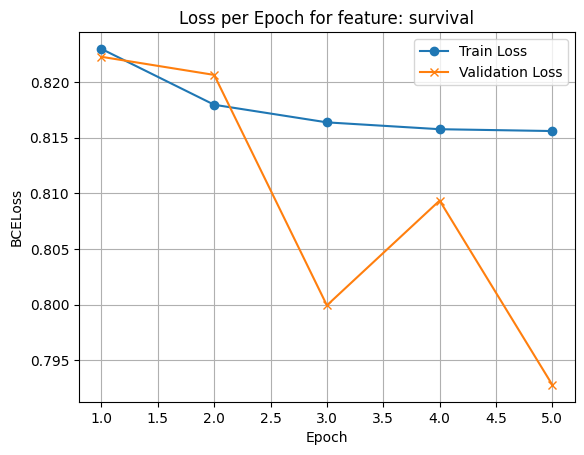

Training global model for feature: socialization


Epoch 1/5, Train Loss: 1.2097, Val Loss: 1.2045


Epoch 2/5, Train Loss: 1.2045, Val Loss: 1.1979


Epoch 3/5, Train Loss: 1.2043, Val Loss: 1.1980


Epoch 4/5, Train Loss: 1.2040, Val Loss: 1.2152


Epoch 5/5, Train Loss: 1.2038, Val Loss: 1.2400


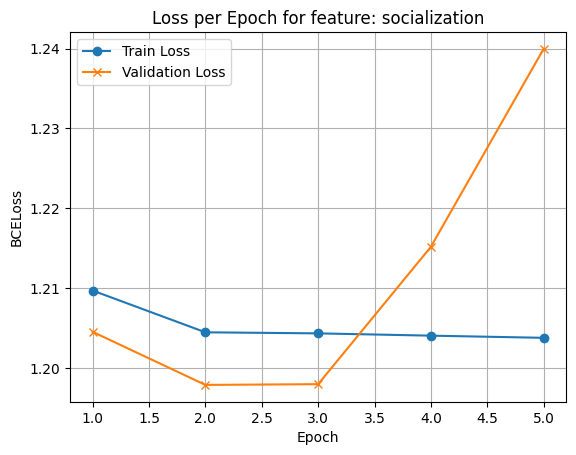

Training global model for feature: self_realization


Epoch 1/5, Train Loss: 1.2282, Val Loss: 1.1327


Epoch 2/5, Train Loss: 1.2213, Val Loss: 1.3748


Epoch 3/5, Train Loss: 1.2210, Val Loss: 1.2088


Epoch 4/5, Train Loss: 1.2210, Val Loss: 1.3410


Epoch 5/5, Train Loss: 1.2206, Val Loss: 1.1851


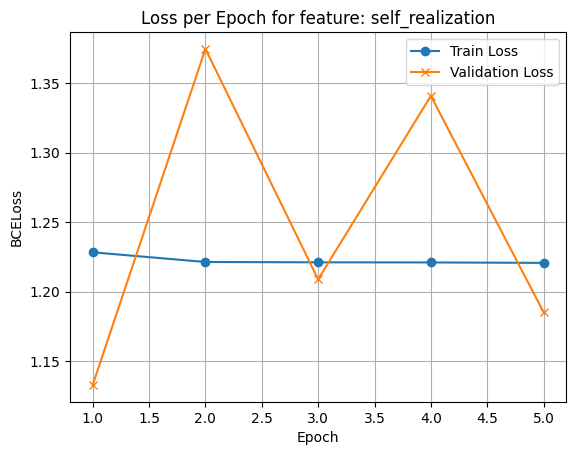

,survival,socialization,self_realization
client,,,
224,"[0.6, 0.6666666666666666, 0.4444444444444444, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.25, 0.25, 0.25, 0.4444444444444444, 0.25, 0..."
1117,"[0.6666666666666666, 0.4444444444444444, 0.666...","[0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1197,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1223,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1555,"[0.4444444444444444, 0.0, 0.0, 0.0, 0.6, 0.571...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
3560436,"[0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3561841,"[0.8333333333333334, 0.8333333333333334, 0.833...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3561945,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.2857142857142857, 0.25, 0.444444444444...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
res = train_lstm_and_compute_f1(parsed_df)
res

In [14]:
def compute_predictability_from_f1(f1_df: pd.DataFrame, threshold: float = 0.5) -> pd.DataFrame:
    rows = []

    for client, row in f1_df.iterrows():
        res = {"client": client}
        hp_values = []

        for feature, f1_scores in row.items():
            if f1_scores is None or len(f1_scores) == 0:
                hp = np.nan
            else:
                hp = (np.asarray(f1_scores) > threshold).mean()

            res[f"{feature}_HP"] = hp

            if not np.isnan(hp):
                hp_values.append(hp)

        if len(hp_values) > 0:
            res["predictability"] = (
                np.linalg.norm(hp_values) / np.sqrt(len(hp_values))
            )
        else:
            res["predictability"] = np.nan

        rows.append(res)

    return pd.DataFrame(rows).set_index("client")


In [15]:
predictability = compute_predictability_from_f1(res)
predictability

,survival_HP,socialization_HP,self_realization_HP,predictability
client,,,,
224,0.591667,0.000000,0.000000,0.341599
1117,0.066667,0.000000,0.000000,0.038490
1197,0.000000,0.000000,0.041667,0.024056
1223,0.008333,0.000000,0.000000,0.004811
1555,0.358333,0.000000,0.050000,0.208888
...,...,...,...,...
3560436,0.008333,0.000000,0.025000,0.015215
3561841,1.000000,0.000000,0.000000,0.577350
3561945,0.216667,0.000000,0.000000,0.125093


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_number_of_customers_by_hit_probability(df, hit_prob_col="hit_probability", bins=20):
    hit_probs = df[hit_prob_col].dropna().values

    counts, bin_edges = np.histogram(hit_probs, bins=bins)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(8, 5))
    plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9)
    plt.xlabel("Hit probability")
    plt.ylabel("Number of customers")
    plt.title("Number of customers by hit probability")
    plt.grid(True)
    plt.show()



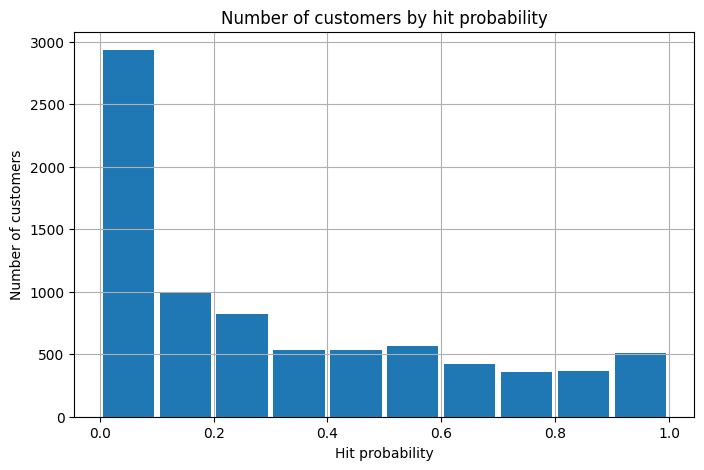

In [18]:
plot_number_of_customers_by_hit_probability(predictability, hit_prob_col="survival_HP", bins=10)

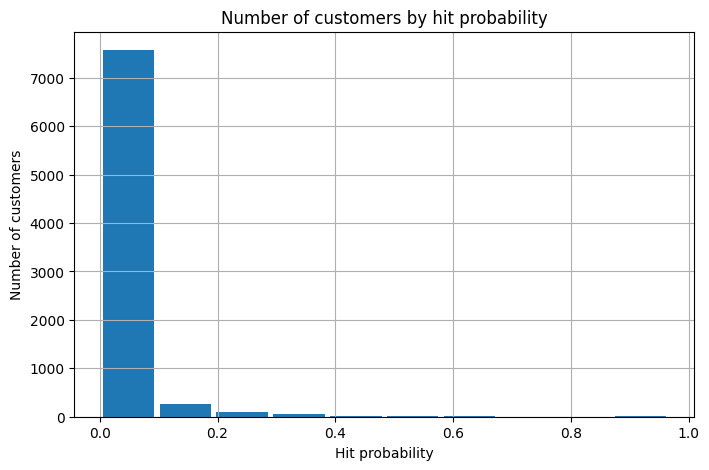

In [19]:
plot_number_of_customers_by_hit_probability(predictability, hit_prob_col="socialization_HP", bins=10)

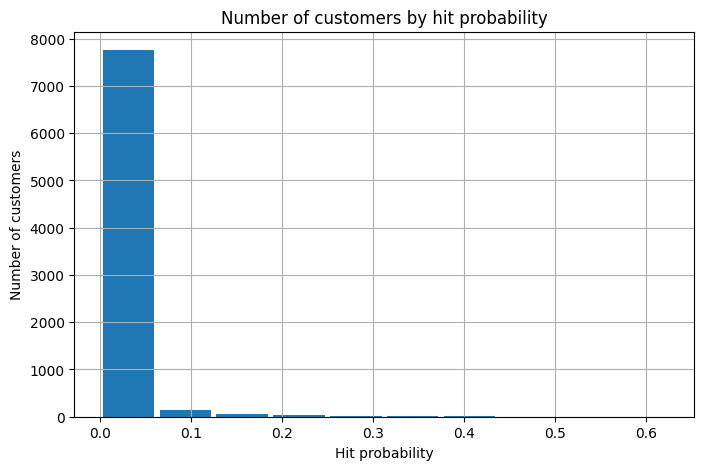

In [20]:
plot_number_of_customers_by_hit_probability(predictability, hit_prob_col="self_realization_HP", bins=10)